In [1]:
def model_prediction_spread(
    model, num_ensembles, initial_values, total_pred_steps, K=1
):
    model_dim = model.model_dim
    predicts_en = np.zeros((total_pred_steps, num_ensembles, model_dim))
    for i in range(num_ensembles):
        predicts_en[0, i] = initial_values[i]
    predicts_temps = predicts_en[0].copy()
    for i in tqdm(range(num_ensembles)):
        for j in range(1, total_pred_steps * K):
            predicts_temps[i] = model.simulate_state(
                predicts_temps[i], num_ensembles=1
            )
            if j % K == 0:
                predicts_en[j // K, i] = predicts_temps[i]
    return predicts_en


def compute_mean_std(u_mean, u_std):
    return (
        u_mean + u_std,
        u_mean - u_std,
        u_mean + 2 * u_std,
        u_mean - 2 * u_std,
    )

In [33]:
import json
import os
import os.path as osp
import sys
import time
from collections import defaultdict, namedtuple

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, skew
from tqdm import tqdm
from multiprocessing import Pool
import seaborn as sns

if "__file__" in globals():
    os.chdir(os.path.dirname(__file__) + "/..")
elif "pkg" not in os.listdir("."):
    os.chdir("..")
sys.path.append(".")

from pkg.ensembleKalmanfilter import (
    EnsembleKalmanFilterSmootherTriad,
    EnsembleKalmanFilterSmootherTriadApprox,
)
from pkg.helper import compute_kde_axis, estimated_autocorrelation
from pkg.utils.misc import AverageMeter, savefig, set_rand_seed

%matplotlib inline
%load_ext autoreload
%autoreload 2

root_folder = "/grad/yli678/workspace/smoother_sampling/output/"
foldername = "triad_model_final/n_steps=200001,regime=1,sigma_obs=0.2"
output_path = root_folder + foldername

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
model = "Triad"

In [4]:
Params = namedtuple(
    "Params", ["gamma_s", "L_s", "sigma_s", "I", "epsilon", "F"]
)

json_filename = output_path + "/true_params_used.json"
with open(json_filename, "r") as f:
    configs_perfect = json.loads(f.read())


params_truth = Params(
    configs_perfect["gamma_s"],
    configs_perfect["L_s"],
    configs_perfect["sigma_s"],
    configs_perfect["I"],  # dim_I
    configs_perfect["epsilon"],  # dim_J
    configs_perfect["F"],  # h
)

json_filename = output_path + "/wrong_params_used.json"
with open(json_filename, "r") as f:
    configs_wrong = json.loads(f.read())

Params_M = namedtuple(
    "Params",
    [
        "gamma_s",
        "L_s",
        "sigma_s",
        "I",
        "epsilon",
        "F",
        "d_M",
        "mean_M",
        "sigma_M",
    ],
)
params_wrong = Params_M(
    configs_wrong["gamma_s"],
    configs_wrong["L_s"],
    configs_wrong["sigma_s"],
    configs_wrong["I"],
    configs_wrong["epsilon"],
    configs_wrong["F"],
    configs_wrong["d_M"],
    configs_wrong["mean_M"],
    configs_wrong["sigma_M"],
)
print(params_truth)
print(params_wrong)

json_filename = output_path + "/config.json"
with open(json_filename, "r") as f:
    configs = json.loads(f.read())

dt = configs["dt"]
obs_dt = configs["obs_dt"]
n_steps = configs["n_steps"]
rand_seed = configs["rand_seed"]
sigma_obs = configs["sigma_obs"]
pred_start_time = configs["pred_start_time"]
pred_total_time = configs["pred_total_time"]
last_lead_time = configs["last_lead_time"]
data_sampling = np.load(output_path + "/sampling.npz")
true_state = data_sampling["true_state"]
wrong_state = data_sampling["wrong_state"]
model_dim = true_state.shape[1]
obs = data_sampling["obs"]
gamma_mean_trace = data_sampling["gamma_mean_trace"]
gamma_cov_trace = data_sampling["gamma_cov_trace"]
gamma_ensembles = data_sampling["gamma_ensembles"]
data_sampling_perfect = np.load(output_path + "/sampling_perfect.npz")
gamma_mean_trace_perfect = data_sampling_perfect["gamma_mean_trace_perfect"]
gamma_cov_trace_perfect = data_sampling_perfect["gamma_cov_trace_perfect"]

data_sampling_for_IC = np.load(output_path + "/sampling_for_IC.npz")
gamma_ensembles_for_IC_short = data_sampling_for_IC[
    "gamma_ensembles_for_IC_short"
]

gamma_mean_smooth = data_sampling["gamma_mean_smooth"]
gamma_cov_smooth = data_sampling["gamma_cov_smooth"]

obs_n_steps = int(dt * (n_steps - 1) / obs_dt) + 1
K = int(obs_dt / dt)
t = np.linspace(0, (n_steps - 1) * dt, n_steps)
t_obs = np.linspace(0, (obs_n_steps - 1) * obs_dt, obs_n_steps)
obs_idx = np.linspace(0, int((obs_n_steps - 1)) * K, obs_n_steps)
obs_idx = obs_idx.astype(int)

trans_mat = np.asarray([[1, 0]])
obs_noise = np.asarray([1]) * sigma_obs
obs_noise

Params(gamma_s=[2, 0.2, 0.4], L_s=[0.2, 0.1, 0], sigma_s=[0.5, 1.2, 0.8], I=5, epsilon=1, F=2)
Params(gamma_s=[2, 0.2, 0.4], L_s=[0.2, 0.1, 0], sigma_s=[0.5, 1.2, 0.8], I=5, epsilon=1, F=2, d_M=[0.7188173093557038, 0.5465733242240679], mean_M=[-1.812763581649797, -0.09556068704723754], sigma_M=[1.3445772269079257, 0.8776251004984976])


array([0.2])

In [5]:
triad_EnKF = EnsembleKalmanFilterSmootherTriad(
    n_steps, model_dim, params_truth, obs_dt, trans_mat, obs_noise
)
triad_EnKF_wrong = EnsembleKalmanFilterSmootherTriadApprox(
    n_steps, model_dim, params_wrong, obs_dt, trans_mat, obs_noise
)

# Model based prediction

In [6]:
pred_dt = obs_dt
pred_n_steps = int(dt * (n_steps - 1) / pred_dt) + 1
pred_K = int(pred_dt / dt)


t_pred = np.linspace(0, (pred_n_steps - 1) * pred_dt, pred_n_steps)
pred_idx = np.linspace(0, int((pred_n_steps - 1)) * pred_K, pred_n_steps)
pred_idx = pred_idx.astype(int)

In [7]:
pred_obs_n_steps = int(obs_dt * (obs_n_steps - 1) / pred_dt) + 1
pred_obs_K = int(pred_dt / obs_dt)


pred_obs_idx = np.linspace(
    0, int((pred_obs_n_steps - 1)) * pred_obs_K, pred_obs_n_steps
)
pred_obs_idx = pred_obs_idx.astype(int)

In [8]:
pred_start_pred_step = int(pred_start_time / pred_dt)
pred_total_pred_steps = int(pred_total_time / pred_dt) + 1

print(f"pred_start_pred_step: {pred_start_pred_step}")
print(f"pred_total_pred_steps: {pred_total_pred_steps}")

print(f"start timeunit: {pred_start_pred_step * pred_dt}")
print(
    f"end timeunit: {(pred_start_pred_step + pred_total_pred_steps) * pred_dt}"
)
print(f"length of entire trajectories: {(n_steps - 1) * dt}")

last_lead_t = int(last_lead_time / dt)
lead_step = pred_K

pred_last_lead_t = last_lead_t // pred_K
pred_lead_step = lead_step // pred_K

lead_time_steps = np.linspace(
    0, last_lead_t, int(last_lead_t / lead_step) + 1
).astype(
    int
)  # only use for plotting
print(f"lead_time_steps (in terms of dt): {lead_time_steps}")
print(f"final lead time: {last_lead_t * dt}")
print(f"total_lead_time_steps: {len(lead_time_steps)}")

pred_start_pred_step: 16000
pred_total_pred_steps: 1601
start timeunit: 800.0
end timeunit: 880.0500000000001
length of entire trajectories: 1000.0
lead_time_steps (in terms of dt): [   0   10   20   30   40   50   60   70   80   90  100  110  120  130
  140  150  160  170  180  190  200  210  220  230  240  250  260  270
  280  290  300  310  320  330  340  350  360  370  380  390  400  410
  420  430  440  450  460  470  480  490  500  510  520  530  540  550
  560  570  580  590  600  610  620  630  640  650  660  670  680  690
  700  710  720  730  740  750  760  770  780  790  800  810  820  830
  840  850  860  870  880  890  900  910  920  930  940  950  960  970
  980  990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110
 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250
 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390
 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530
 1540 1550 1560 1570 1580 1590 1600 1

In [9]:
t_target = t[pred_idx][
    pred_start_pred_step : pred_start_pred_step + pred_total_pred_steps
]
target = true_state[pred_idx][
    pred_start_pred_step : pred_start_pred_step + pred_total_pred_steps
]

In [10]:
model_prediction_data = np.load(output_path + "/dynamicalmodels.npz")
predict_mean = model_prediction_data["predict_mean"]
predict_wrong = model_prediction_data["predict_wrong"]
rmse_perfect = model_prediction_data["rmse_perfect"]
rmse_wrong = model_prediction_data["rmse_wrong"]
corr_perfect = model_prediction_data["corr_perfect"]
corr_wrong = model_prediction_data["corr_wrong"]
predict_mean_DA = model_prediction_data["predict_mean_DA"]
predict_wrong_DA = model_prediction_data["predict_wrong_DA"]
rmse_perfect_DA = model_prediction_data["rmse_perfect_DA"]
rmse_wrong_DA = model_prediction_data["rmse_wrong_DA"]
corr_perfect_DA = model_prediction_data["corr_perfect_DA"]
corr_wrong_DA = model_prediction_data["corr_wrong_DA"]

## prediction spread

In [11]:
pred_num_ensembles = 2500
spread_total_pred_steps = 201
spread_initial_time = 5
spread_start_time = pred_start_time + spread_initial_time
spread_start_time_step = int(spread_start_time / pred_dt)
spread_target = true_state[pred_idx][
    spread_start_time_step : spread_start_time_step + spread_total_pred_steps
]
spread_t = t_pred[
    spread_start_time_step : spread_start_time_step + spread_total_pred_steps
]
spread_initial_values = true_state[pred_idx][spread_start_time_step]
spread_initial_values_repeat = np.zeros((pred_num_ensembles, model_dim))
spread_initial_mean = gamma_mean_trace[pred_obs_idx][spread_start_time_step]
spread_initial_cov = gamma_cov_trace[pred_obs_idx][spread_start_time_step]
spread_initial_mean_perfect = gamma_mean_trace_perfect[pred_obs_idx][
    spread_start_time_step
]
spread_initial_cov_perfect = gamma_cov_trace_perfect[pred_obs_idx][
    spread_start_time_step
]

spread_initial_DA = np.zeros((pred_num_ensembles, model_dim))
spread_initial_DA_perfect = np.zeros((pred_num_ensembles, model_dim))

for i in range(pred_num_ensembles):
    spread_initial_values_repeat[i] = spread_initial_values

spread_initial_DA = np.random.multivariate_normal(
    spread_initial_mean, spread_initial_cov, pred_num_ensembles
)
spread_initial_DA_perfect = np.random.multivariate_normal(
    spread_initial_mean_perfect, spread_initial_cov_perfect, pred_num_ensembles
)

In [12]:
def model_prediction_spread_func_triad_EnKF_DA(i):
    initial_values = spread_initial_DA_perfect[i]
    model = triad_EnKF
    set_rand_seed(i)
    model_dim = model.model_dim
    total_pred_steps = spread_total_pred_steps
    predicts_en = np.empty((total_pred_steps, model_dim))
    predicts_en = [[0] * model_dim] * total_pred_steps
    predicts_en[0] = initial_values.tolist()
    predicts_temps = np.asarray(predicts_en[0])
    for j in range(1, total_pred_steps * K):
        predicts_temps = model.simulate_state(predicts_temps, num_ensembles=1)
        if j % K == 0:
            predicts_en[j // K] = predicts_temps.tolist()
    return predicts_en


def model_prediction_spread_func_triad_wrong_EnKF_DA(i):
    initial_values = spread_initial_DA[i]
    model = triad_EnKF_wrong
    set_rand_seed(i)
    model_dim = model.model_dim
    total_pred_steps = spread_total_pred_steps
    predicts_en = np.empty((total_pred_steps, model_dim))
    predicts_en = [[0] * model_dim] * total_pred_steps
    predicts_en[0] = initial_values.tolist()
    predicts_temps = np.asarray(predicts_en[0])
    for j in range(1, total_pred_steps * K):
        predicts_temps = model.simulate_state(predicts_temps, num_ensembles=1)
        if j % K == 0:
            predicts_en[j // K] = predicts_temps.tolist()
    return predicts_en

In [13]:
hhhh = list(range(pred_num_ensembles))
start_time = time.time()
set_rand_seed(rand_seed)
with Pool() as p:
    results_ = p.map(model_prediction_spread_func_triad_EnKF_DA, hhhh)

predicts_en_DA = np.zeros(
    (spread_total_pred_steps, pred_num_ensembles, model_dim)
)
for i in range(pred_num_ensembles):
    predicts_en_DA[:, i, :] = results_[i]
print(time.time() - start_time)

7.16122579574585


In [14]:
hhhh = list(range(pred_num_ensembles))
start_time = time.time()
set_rand_seed(rand_seed)
with Pool() as p:
    results_ = p.map(model_prediction_spread_func_triad_wrong_EnKF_DA, hhhh)

predicts_en_wrong_DA = np.zeros(
    (spread_total_pred_steps, pred_num_ensembles, model_dim)
)
for i in range(pred_num_ensembles):
    predicts_en_wrong_DA[:, i, :] = results_[i]
print(time.time() - start_time)

5.809119462966919


# LSTM prediction spread

## load LSTM model based on different lead time

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (h_n, c_n) = self.rnn(
            x
        )  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = self.fc(out)
        return out

    def train_epoch(
        self,
        train_dataloader,
        optimizer,
        valid_dataloader=None,
        **kwargs,
    ):
        self.train()
        train_metrics = defaultdict(AverageMeter)
        step = 0

        for X, y in train_dataloader:
            output = self(X)
            loss = F.mse_loss(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            step += 1
            train_metrics["loss"].update(loss.item(), X.shape[0])

        if valid_dataloader:
            eval_metrics = self.evaluate(valid_dataloader)
        else:
            eval_metrics = None

        return (
            train_metrics,
            eval_metrics,
        )

    def evaluate(self, dataloader):
        metrics = defaultdict(AverageMeter)
        self.eval()
        step = 0
        with torch.no_grad():
            for X, y in dataloader:
                output = self(X)

                loss = F.mse_loss(output, y)
                step += 1
                metrics["loss"].update(loss.item(), X.shape[0])
        return metrics


class SampledTrajectoriesData(Dataset):
    def __init__(self, data):
        """
        data is a tuple, given the input of lstm and the true output
        """
        self.data = data

    def __len__(self):
        return self.data[0].shape[0]

    def __getitem__(self, idx):
        X, y = self.data[0], self.data[1]
        return X[idx], y[idx]  # use iterable as return, no need to implement

In [16]:
predicts_en_lstm_DA = np.zeros(
    (predicts_en_wrong_DA.shape[0], 50, predicts_en_wrong_DA.shape[2])
)

In [18]:
predicts_en_lstm_smoother_DA = np.zeros(
    (predicts_en_wrong_DA.shape[0], 1, predicts_en_wrong_DA.shape[2])
)

In [19]:
predicts_en_lstm_DA_std = np.zeros(
    (predicts_en_lstm_DA.shape[0], predicts_en_lstm_DA.shape[2])
)

In [20]:
predicts_en_lstm_DA_std_smooth = np.zeros(
    (predicts_en_lstm_DA.shape[0], predicts_en_lstm_DA.shape[2])
)

In [21]:
predicts_en_lstm_DA_std = np.zeros(predicts_en_lstm_DA.shape)

In [22]:
predicts_en_lstm_DA_std_train = np.zeros(
    (predicts_en_lstm_DA.shape[0], predicts_en_lstm_DA.shape[2])
)

In [23]:
predicts_en_lstm_DA_std_ls = [[] for _ in range(2)]

In [24]:
train_dim_idx = np.arange(0, model_dim)

In [25]:
def pred_lstm_update(
    lstm_LT_output_path,
    suffix,
    lead_time,
    lstm_model,
    spread_total_pred_steps,
    spread_initial_time,
    pred_dt,
    training_type,
):
    model_path = osp.join(lstm_LT_output_path, "model_" + suffix + ".pt")
    json_filename = osp.join(
        lstm_LT_output_path, "val_err_details_" + suffix + ".json"
    )
    with open(json_filename, "r") as f:
        val_err = json.loads(f.read())
    val_arr_ind = val_err["val_arr_ind_details"]
    json_filename = osp.join(
        lstm_LT_output_path, "train_err_" + suffix + ".json"
    )
    with open(json_filename, "r") as f:
        train_err = json.loads(f.read())
    train_arr_ind = train_err["train_arr_ind"]
    for dim in range(model_dim):
        # actually, this is not useful
        if training_type == "imperfect":
            predicts_en_lstm_DA_std_train[lead_time, dim] = np.sqrt(
                train_arr_ind[dim]
            )
            for sampled_dim in range(50):
                predicts_en_lstm_DA_std[lead_time, sampled_dim, dim] = np.sqrt(
                    val_arr_ind[dim][sampled_dim]
                )
        elif training_type == "imperfect_smooth":
            predicts_en_lstm_DA_std_smooth[lead_time, dim] = np.sqrt(
                val_arr_ind[dim]
            )
    json_filename = osp.join(
        lstm_LT_output_path, "val_err_details_full_" + suffix + ".json"
    )

    with open(json_filename, "r") as f:
        val_err_full = json.loads(f.read())
    val_arr_ind_full = val_err_full["val_arr_ind_details"]

    lstm_model.load_state_dict(torch.load(model_path))

    lstm_model.eval()
    spread_total_pred_steps_ = (
        int(spread_initial_time // pred_dt) + spread_total_pred_steps + 200
    )

    for i in range(50):
        if (
            training_type == "imperfect"
            or training_type == "imperfect_long_multi"
        ):
            initial_samples = gamma_ensembles_for_IC_short[
                (pred_last_lead_t - lead_time + 1) : (
                    pred_last_lead_t - lead_time + spread_total_pred_steps_ + 1
                ),
                :,
                train_dim_idx,
                i,
            ]
        elif training_type == "imperfect_smooth":
            initial_samples = np.mean(
                gamma_ensembles_for_IC_short[
                    (pred_last_lead_t - lead_time)
                    + 1 : (
                        pred_last_lead_t
                        - lead_time
                        + spread_total_pred_steps_
                        + 1
                    ),
                    :,
                    train_dim_idx,
                    :,
                ],
                axis=3,
            )
        elif training_type == "imperfect_long":
            initial_samples = gamma_ensembles_for_IC_short[
                (pred_last_lead_t - lead_time)
                + 1 : (
                    pred_last_lead_t - lead_time + spread_total_pred_steps_ + 1
                ),
                :,
                train_dim_idx,
                1,
            ]
        initial_values_LSTM = initial_samples[:, 1:, :]
        # y_pred here is useless!!!
        X_pred, y_pred = (
            torch.from_numpy(np.asarray(initial_values_LSTM[:, :, :])).float(),
            torch.from_numpy(np.asarray(initial_values_LSTM[:, :, :])).float(),
        )
        pred_traj_data = SampledTrajectoriesData((X_pred, y_pred))
        pred_dataloader = DataLoader(
            pred_traj_data, batch_size=int(spread_total_pred_steps_)
        )
        with torch.no_grad():
            for X, y in pred_dataloader:
                output = lstm_model(X)
                if training_type == "imperfect":
                    #                     print(nt(spread_initial_time // pred_dt) + lead_time)
                    predicts_en_lstm_DA[lead_time, i, :] = output[:, -1, :][
                        int(spread_initial_time // pred_dt) + lead_time
                    ].numpy()
                elif training_type == "imperfect_smooth":
                    predicts_en_lstm_smoother_DA[lead_time, 0, :] = output[
                        :, -1, :
                    ][int(spread_initial_time // pred_dt) + lead_time].numpy()
                elif training_type == "imperfect_long":
                    predicts_en_lstm_long_DA[lead_time, 0, :] = output[
                        :, -1, :
                    ][int(spread_initial_time // pred_dt) + lead_time].numpy()
                elif training_type == "imperfect_long_multi":
                    predicts_en_lstm_long_DA_multi[lead_time, i, :] = output[
                        :, -1, :
                    ][int(spread_initial_time // pred_dt) + lead_time].numpy()

    return val_arr_ind_full

In [26]:
def update(lead_time, hidden_size, num_epochs, lr, n_segments, training_type):
    lstm_model = LSTM(
        input_size=model_dim,
        hidden_size=hidden_size,
        num_layers=1,
        output_size=model_dim,
    )
    suffix = (
        f"hidden_size={hidden_size},lr={lr},batch_size=64,"
        + f"num_epochs={num_epochs},weight_decay=0.0,n_segments={n_segments}"
    )
    if training_type == "imperfect_long_multi":
        lstm_output_path = osp.join(
            output_path, "_lstm_training_type=imperfect_long"
        )
    else:
        lstm_output_path = osp.join(
            output_path, "_lstm_training_type=" + training_type
        )
    lstm_LT_output_path = osp.join(
        lstm_output_path, "lead_time=" + str(lead_time)
    )
    val_arr_ind_full = pred_lstm_update(
        lstm_LT_output_path,
        suffix,
        lead_time,
        lstm_model,
        spread_total_pred_steps,
        spread_initial_time,
        pred_dt,
        training_type,
    )
    return val_arr_ind_full

In [27]:
val_arr_ind_full_arr = []
for i in range(201):
    val_arr_ind_full_arr.append(np.empty)

In [28]:
val_arr_ind_full_arr_smooth = []
for i in range(201):
    val_arr_ind_full_arr_smooth.append(np.empty)

In [29]:
for lead_time in tqdm([2]):
    val_arr_ind_full_arr[lead_time] = np.asarray(
        update(lead_time, 64, 200, 0.0005, 120, "imperfect")
    )
for lead_time in tqdm([20]):
    val_arr_ind_full_arr[lead_time] = np.asarray(
        update(lead_time, 32, 50, 0.001, 120, "imperfect")
    )
for lead_time in tqdm([80, 100]):
    val_arr_ind_full_arr[lead_time] = np.asarray(
        update(lead_time, 16, 30, 0.001, 100, "imperfect")
    )

100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


In [31]:
for lead_time in tqdm([2]):
    val_arr_ind_full_arr_smooth[lead_time] = np.asarray(
        update(lead_time, 64, 1000, 0.001, 120, "imperfect_smooth")
    )
for lead_time in tqdm([20]):
    val_arr_ind_full_arr_smooth[lead_time] = np.asarray(
        update(lead_time, 32, 500, 0.001, 120, "imperfect_smooth")
    )
for lead_time in tqdm([80]):
    val_arr_ind_full_arr_smooth[lead_time] = np.asarray(
        update(lead_time, 16, 500, 0.001, 100, "imperfect_smooth")
    )

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


In [35]:
lead_times = [2, 20, 80]

In [36]:
for i in range(50):
    predicts_en_lstm_DA[0, i] = gamma_ensembles_for_IC_short[
        (pred_last_lead_t + int(spread_initial_time // pred_dt)) + 1,
        -1,
        train_dim_idx,
        i,
    ]

In [37]:
predicts_en_DA_std = np.std(predicts_en_DA, axis=1)
predicts_en_wrong_DA_std = np.std(predicts_en_wrong_DA, axis=1)

In [38]:
num_reconst_ = 2500
reconstruct_lstm_samples = np.zeros((201, 50 * num_reconst_, model_dim))
reconstruct_lstm_samples_smooth = np.zeros((201, 1 * num_reconst_, model_dim))

In [39]:
reconstruct_lstm_samples.shape

(201, 125000, 3)

In [40]:
loop_ls = list(range(50))

In [41]:
for plt_dim in tqdm(range(model_dim)):
    for plt_time in [2, 20, 80, 100]:
        set_rand_seed(rand_seed)
        kde_u, u_axis = compute_kde_axis(
            val_arr_ind_full_arr[plt_time].reshape(model_dim, -1)[plt_dim],
            dist=1,
        )
        p = (kde_u(u_axis) / np.sum(kde_u(u_axis))).tolist()
        ls = [
            np.random.choice(
                u_axis, p=p  # (kde_u(u_axis) / np.sum(kde_u(u_axis))).tolist()
            )
            for _ in range(num_reconst_)
        ]
        for i in loop_ls:
            if plt_time >= 150:
                reconstruct_lstm_samples[
                    plt_time,
                    i * num_reconst_ : (i + 1) * num_reconst_,
                    plt_dim,
                ] = (
                    np.mean(predicts_en_lstm_DA[plt_time, :, plt_dim]) + ls
                )
            else:
                reconstruct_lstm_samples[
                    plt_time,
                    i * num_reconst_ : (i + 1) * num_reconst_,
                    plt_dim,
                ] = (
                    predicts_en_lstm_DA[plt_time, i, plt_dim] + ls
                )

100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


In [42]:
for plt_dim in tqdm(range(model_dim)):
    for plt_time in [2, 20, 80]:
        set_rand_seed(rand_seed)
        kde_u, u_axis = compute_kde_axis(
            val_arr_ind_full_arr_smooth[plt_time].reshape(model_dim, -1)[
                plt_dim
            ],
            dist=1,
        )
        p = (kde_u(u_axis) / np.sum(kde_u(u_axis))).tolist()
        ls = [
            np.random.choice(
                u_axis, p=p  # (kde_u(u_axis) / np.sum(kde_u(u_axis))).tolist()
            )
            for _ in range(num_reconst_)
        ]
        for i in [0]:

            reconstruct_lstm_samples_smooth[
                plt_time,
                i * num_reconst_ : (i + 1) * num_reconst_,
                plt_dim,
            ] = (
                predicts_en_lstm_smoother_DA[plt_time, i, plt_dim] + ls
            )

100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


## Plot u1

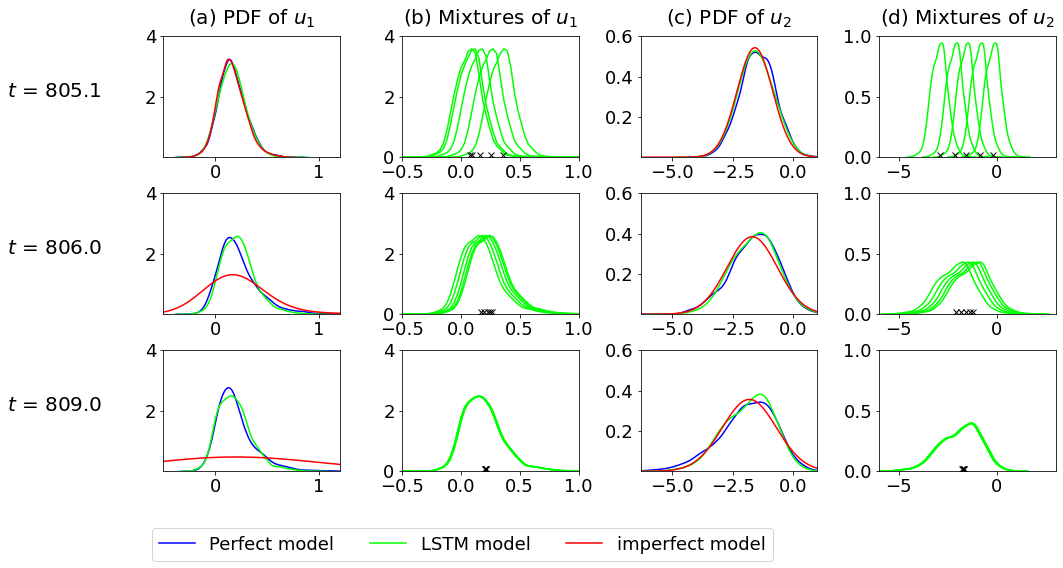

In [43]:
fontsize = 18
plt.rc("axes", titlepad=12)
plt.rc("axes", titlesize=fontsize + 2)
plt.rc("axes", labelsize=fontsize + 2)
plt.rc("xtick", labelsize=fontsize)
plt.rc("ytick", labelsize=fontsize)
plt.rc("legend", fontsize=fontsize)

fig, axs = plt.subplots(
    nrows=3,
    ncols=4,
    figsize=(16, 8),
)
plt_times = [2, 20, 80]
plt_dim = 0
u_axis_non_lr = np.linspace(-4, 5, num=300)
for i in range(len(plt_times)):
    plt_time = plt_times[i]
    kde_u, axis = compute_kde_axis(
        predicts_en_DA[plt_time, :, plt_dim], 300, dist=3
    )
    u = predicts_en_DA[plt_time, :, plt_dim]
    sns.kdeplot(
        data=u, bw_adjust=1, ax=axs[i, 0], color="b", label="Perfect model"
    )

    u = reconstruct_lstm_samples[plt_time, :, plt_dim]
    sns.kdeplot(
        data=u, bw_adjust=2, ax=axs[i, 0], color="lime", label="LSTM model"
    )

    if plt_dim == 0 and plt_time >= 20:
        predicts_en_wrong_DA[plt_time, :, plt_dim].sort()
        u = predicts_en_wrong_DA[plt_time, :, plt_dim][:2490]
        sns.kdeplot(data=u, bw_adjust=3, ax=axs[i, 0], color="r")
    else:
        u = predicts_en_wrong_DA[plt_time, :, plt_dim]
        sns.kdeplot(
            data=u,
            bw_adjust=1,
            ax=axs[i, 0],
            color="r",
            label="imperfect model",
        )
    axs[i, 0].set_ylabel(None)
u_axis_ref = np.linspace(-1.5, 3, num=300)
for i in range(len(plt_times)):
    plt_time = plt_times[i]
    for idx in [0, 7, 24, 42, 49]:
        j = np.argsort(predicts_en_lstm_DA[plt_time, :, plt_dim])[idx]
        kde_u, _ = compute_kde_axis(
            reconstruct_lstm_samples[
                plt_time, num_reconst_ * j : num_reconst_ * (j + 1), plt_dim
            ],
            300,
            dist=0.5,
        )
        axs[i, 1].plot(u_axis_non_lr, kde_u(u_axis_non_lr), "lime")
for i in range(len(plt_times)):
    plt_time = plt_times[i]
    for idx in [0, 7, 24, 42, 49]:
        j = np.argsort(predicts_en_lstm_DA[plt_time, :, plt_dim])[idx]
        axs[i, 1].plot(
            [predicts_en_lstm_DA[plt_time, j, plt_dim]],
            [0.06],
            "x",
            color="black",
        )

plt_dim = 1
u_axis_non_lr = np.linspace(-7, 5, num=300)

for i in range(len(plt_times)):
    plt_time = plt_times[i]

    if plt_dim == 5 and plt_time == 80:
        u = np.empty(50)
        for idx in [24]:
            j = np.argsort(predicts_en_lstm_DA[plt_time, :, plt_dim])[idx]
            u = np.hstack(
                (
                    u,
                    reconstruct_lstm_samples[
                        plt_time,
                        num_reconst_ * j : num_reconst_ * (j + 1),
                        plt_dim,
                    ],
                )
            )

            sns.kdeplot(data=u, bw_adjust=1.5, ax=axs[i, 2], color="lime")
            u = predicts_en_DA[plt_time, :, plt_dim]
            sns.kdeplot(data=u, bw_adjust=1.5, ax=axs[i, 2], color="b")
            kde_u, axis = compute_kde_axis(
                predicts_en_wrong_DA[plt_time, :, plt_dim], 300, dist=3
            )
            axs[i, 2].plot(u_axis_non_lr, kde_u(u_axis_non_lr), color="r")

            axs[i, 2].set_ylabel(None)
    else:
        u = predicts_en_DA[plt_time, :, plt_dim]
        sns.kdeplot(data=u, bw_adjust=1, ax=axs[i, 2], color="b")
        u = reconstruct_lstm_samples[plt_time, :, plt_dim]
        sns.kdeplot(data=u, bw_adjust=3, ax=axs[i, 2], color="lime")
        u = predicts_en_wrong_DA[plt_time, :, plt_dim]
        u_mean, u_std = norm.fit(u)
        axs[i, 2].plot(
            u_axis_non_lr, norm.pdf(u_axis_non_lr, u_mean, u_std), color="r"
        )

    axs[i, 2].set_ylabel(None)


u_axis_ref = np.linspace(-7, 5, num=300)
for i in range(len(plt_times)):
    plt_time = plt_times[i]

    for idx in [0, 7, 24, 42, 49]:
        j = np.argsort(predicts_en_lstm_DA[plt_time, :, plt_dim])[idx]
        kde_u, _ = compute_kde_axis(
            reconstruct_lstm_samples[
                plt_time, num_reconst_ * j : num_reconst_ * (j + 1), plt_dim
            ],
            300,
            dist=1,
        )
        u = reconstruct_lstm_samples[
            plt_time, num_reconst_ * j : num_reconst_ * (j + 1), plt_dim
        ]
        sns.kdeplot(data=u, bw_adjust=1, ax=axs[i, 3], color="lime")
        axs[i, 3].set_ylabel(None)
for i in range(len(plt_times)):
    plt_time = plt_times[i]
    for idx in [0, 7, 24, 42, 49]:
        j = np.argsort(predicts_en_lstm_DA[plt_time, :, plt_dim])[idx]
        axs[i, 3].plot(
            [predicts_en_lstm_DA[plt_time, j, plt_dim]],
            [0.02],
            "x",
            color="black",
        )
u = predicts_en_DA[plt_times[-1], :, 0]
u_mean, u_std = norm.fit(u)


for i in [0, 1, 2]:
    for j in range(4):
        y_bottom = 0
        if j == 0:
            x_left = -0.5
            x_right = 1.2
            y_top = 4
            y_bottom = 10 ** (-2)
        elif j == 1:
            x_left = -0.5
            x_right = 1
            y_bottom = 0
        elif j == 2:
            x_left = -1.8089 - 4.5
            x_right = 1
            y_top = 0.6
            y_bottom = 10 ** (-3)
        elif j == 3:
            x_left = -6
            x_right = 3
            y_top = 1
            y_bottom = 0
        axs[i, j].set_xlim([x_left, x_right])
        axs[i, j].set_ylim([y_bottom, y_top])


x_loc = -2
y_loc = 2
for i in range(3):
    axs[i, 0].text(
        x_loc,
        y_loc,
        f"$t$ = {spread_initial_time + pred_start_time + plt_times[i] * obs_dt}",
        fontsize=fontsize + 2,
    )

axs[0, 0].set_title("(a) PDF of $u_1$", pad=12)
axs[0, 1].set_title("(b) Mixtures of $u_1$", pad=12)
axs[0, 2].set_title("(c) PDF of $u_2$", pad=12)
axs[0, 3].set_title("(d) Mixtures of $u_2$", pad=12)
plt.subplots_adjust(hspace=0.3, wspace=0.35)
handles, labels = axs[0, 0].get_legend_handles_labels()
axs[-1, 0].legend(handles, labels, ncol=3, bbox_to_anchor=(3.5, -0.4))
savefig(
    fig,
    osp.join(
        output_path,
        model
        + f"_recovered_PDFs_from_{spread_initial_time + pred_start_time}"
        + f"_to_{spread_initial_time + pred_start_time + plt_times[-1] * obs_dt}.pdf",
    ),
)

In [44]:
for plt_time in plt_times:
    print(f"Perfect: {round(skew(predicts_en_DA[plt_time, :, plt_dim]), 3)}")
    print(
        f"Imperfect: {round(skew(predicts_en_wrong_DA[plt_time, :, plt_dim]), 3)}"
    )

    print(
        f"lstm: {round(skew(reconstruct_lstm_samples[plt_time, :, plt_dim]), 3)}"
    )
    print("\n")

Perfect: -0.041
Imperfect: 0.07
lstm: 0.017


Perfect: -0.332
Imperfect: 0.062
lstm: -0.108


Perfect: -0.577
Imperfect: -0.032
lstm: -0.365




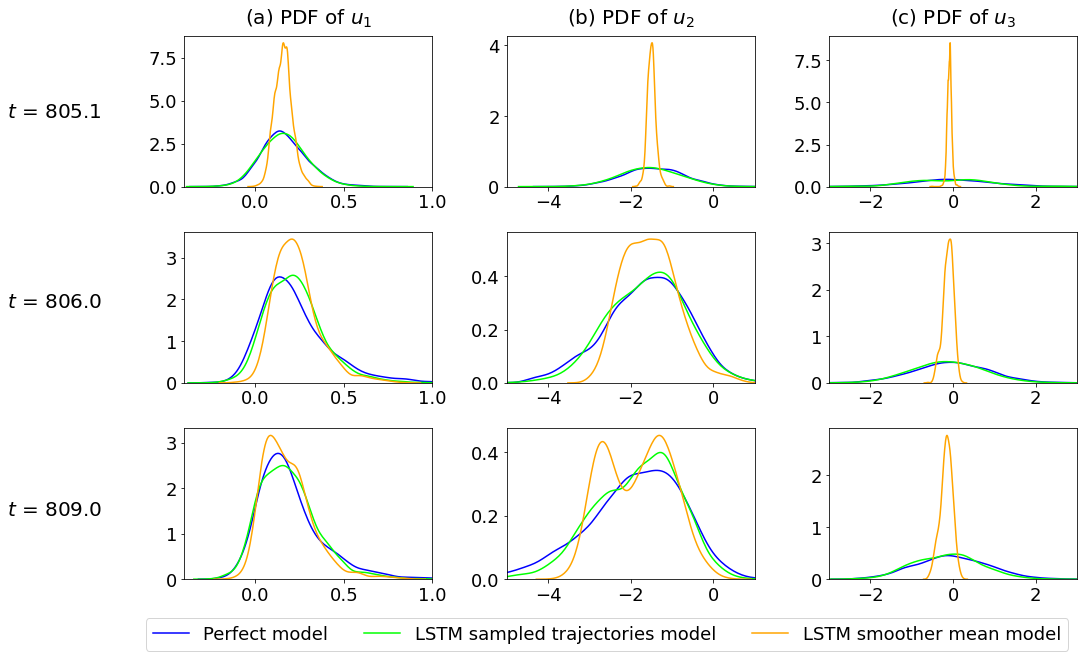

In [45]:
fontsize = 18
plt.rc("axes", titlepad=12)
plt.rc("axes", titlesize=fontsize + 2)
plt.rc("axes", labelsize=fontsize + 2)
plt.rc("xtick", labelsize=fontsize)
plt.rc("ytick", labelsize=fontsize)
plt.rc("legend", fontsize=fontsize)

fig, axs = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(16, 10),
)
plt_times = [2, 20, 80]

plt_dim = 0
u_axis_non_lr = np.linspace(-4, 5, num=300)
for plt_dim in range(model_dim):
    for i in range(len(plt_times)):
        plt_time = plt_times[i]
        u = predicts_en_DA[plt_time, :, plt_dim]
        sns.kdeplot(
            data=u,
            bw_adjust=1,
            ax=axs[i, plt_dim],
            color="b",
            label="Perfect model",
        )

        u = reconstruct_lstm_samples[plt_time, :, plt_dim]
        sns.kdeplot(
            data=u,
            bw_adjust=2,
            ax=axs[i, plt_dim],
            color="lime",
            label="LSTM sampled trajectories model",
        )

        u = reconstruct_lstm_samples_smooth[plt_time, :, plt_dim]
        if plt_time == 80 and plt_time == 1:
            sns.kdeplot(
                data=u,
                bw_adjust=30,
                ax=axs[i, plt_dim],
                color="orange",
                label="LSTM smoother mean model",
            )
        else:
            sns.kdeplot(
                data=u,
                bw_adjust=1.1,
                ax=axs[i, plt_dim],
                color="orange",
                label="LSTM smoother mean model",
            )

        axs[i, plt_dim].set_ylabel(None)

for i in [0, 1, 2]:
    for j in range(3):
        y_bottom = 0
        if j == 0:
            x_left = -0.4
            x_right = 1
        elif j == 1:
            x_left = -5
            x_right = 1
        elif j == 2:
            x_left = -3
            x_right = 3
        axs[i, j].set_xlim([x_left, x_right])
        axs[i, j].set_ylim(bottom=0)


x_loc = -1.4
y_loc = 1
for i in range(3):
    if i == 0:
        y_loc = 4
    elif i == 1:
        y_loc = 1.8
    elif i == 2:
        y_loc = 1.4
    axs[i, 0].text(
        x_loc,
        y_loc,
        f"$t$ = {spread_initial_time + pred_start_time + plt_times[i] * obs_dt}",
        fontsize=fontsize + 2,
    )

axs[0, 0].set_title("(a) PDF of $u_1$")
axs[0, 1].set_title("(b) PDF of $u_2$")
axs[0, 2].set_title("(c) PDF of $u_3$")
plt.subplots_adjust(hspace=0.3, wspace=0.3)
handles, labels = axs[0, 0].get_legend_handles_labels()
axs[-1, 0].legend(handles, labels, ncol=3, bbox_to_anchor=(3.6, -0.2))
savefig(
    fig,
    osp.join(
        output_path,
        model
        + f"_recovered_PDFs_with_smoother_{spread_initial_time + pred_start_time}"
        + f"_to_{spread_initial_time + pred_start_time + plt_times[-1] * obs_dt}.pdf",
    ),
)

In [46]:
i = 1
skewness_ave = 0
print(f"Skewness truth: {skew(true_state[obs_idx, i])}")
print(f"Skewness imperfect: {skew(wrong_state[obs_idx, i])}")
for j in range(50):
    skewness_ave += skew(gamma_ensembles[:, i, j])
print(f"Skewness sampled: {skew(gamma_ensembles[:, i, j])}")
print(f"Skewness sampled ave: {skewness_ave / 50}")
print("\n")

Skewness truth: -0.5258103789866383
Skewness imperfect: -0.05963819453744089
Skewness sampled: -0.2790143403247015
Skewness sampled ave: -0.35555033837934985




## the sampled trajectories

In [82]:
if n_steps > 200000:
    burnin = 600  # in dt space
else:
    burnin = 150
obs_burnin = burnin // K  # in obs_dt space

auto_obs_steps = obs_n_steps - obs_burnin
t_auto = np.linspace(0, (auto_obs_steps - 1) * obs_dt, auto_obs_steps)
acf_u_truth = np.zeros((auto_obs_steps, model_dim))
for i in tqdm(range(model_dim)):
    acf_u_truth[:, i] = estimated_autocorrelation(
        true_state[obs_idx, i][obs_burnin:]
    )

100%|██████████| 3/3 [00:00<00:00,  6.75it/s]


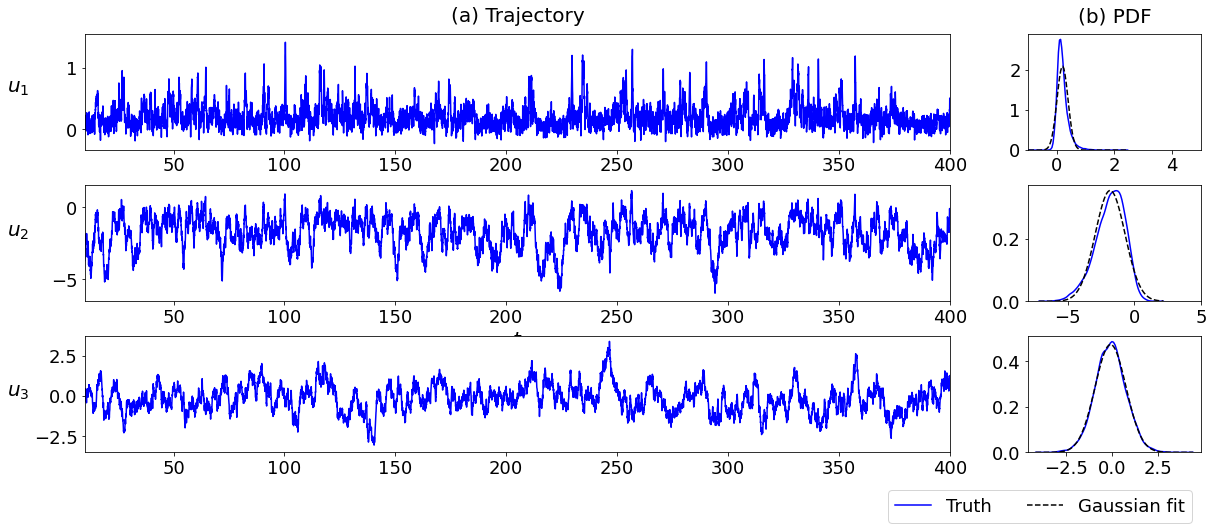

In [64]:
fontsize = 18
plt.rc("axes", titlepad=12)
plt.rc("axes", titlesize=fontsize + 2)
plt.rc("axes", labelsize=fontsize + 2)
plt.rc("xtick", labelsize=fontsize)
plt.rc("ytick", labelsize=fontsize)
plt.rc("legend", fontsize=fontsize)

fig, axs = plt.subplots(
    nrows=model_dim,
    ncols=2,
    figsize=(20, 2.5 * (model_dim)),
    gridspec_kw={"width_ratios": [5, 1]},
)

x_left = 10
x_right = 400

for i in range(model_dim):
    plt_dim = i
    axs[i, 0].plot(
        t_obs[obs_burnin:],
        true_state[obs_idx, plt_dim][obs_burnin:],
        "b",
        label="Truth",
    )
    axs[i, 0].set_xlim([x_left, x_right])
    u = true_state[obs_idx, plt_dim][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u, dist=1)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="b", label="Truth")

    u_mean, u_std = norm.fit(u)
    axs[i, 1].plot(
        u_axis,
        norm.pdf(u_axis, u_mean, u_std),
        "--",
        color="black",
        label="Gaussian fit",
    )
    axs[i, 0].set_xlim([x_left, x_right])
    axs[i, 1].set_ylim(bottom=0)
    axs[i, 0].locator_params(axis="y", nbins=3)
    axs[i, 1].locator_params(nbins=3)

x_loc = x_left - 35
axs[0, 0].text(x_loc, 0.6, "$u_1$", fontsize=fontsize + 2)
axs[1, 0].text(x_loc, -2, "$u_2$", fontsize=fontsize + 2)
axs[2, 0].text(x_loc, 0, "$u_3$", fontsize=fontsize + 2)
axs[0, 1].set_xlim([-1, 5])
axs[1, 1].set_xlim([-8, 5])

axs[0, 0].set_title("(a) Trajectory")
axs[0, 1].set_title("(b) PDF")
axs[1, 0].set_xlabel("$t$")

handles, labels = axs[0, -1].get_legend_handles_labels()
axs[-1, -1].legend(
    handles, labels, ncol=2, loc="upper right", bbox_to_anchor=(1, -0.25)
)
plt.subplots_adjust(hspace=0.3, wspace=0.15, top=0.9)
savefig(fig, osp.join(output_path, model + "_trajectory_truth" + ".pdf"))

plt.rcdefaults()

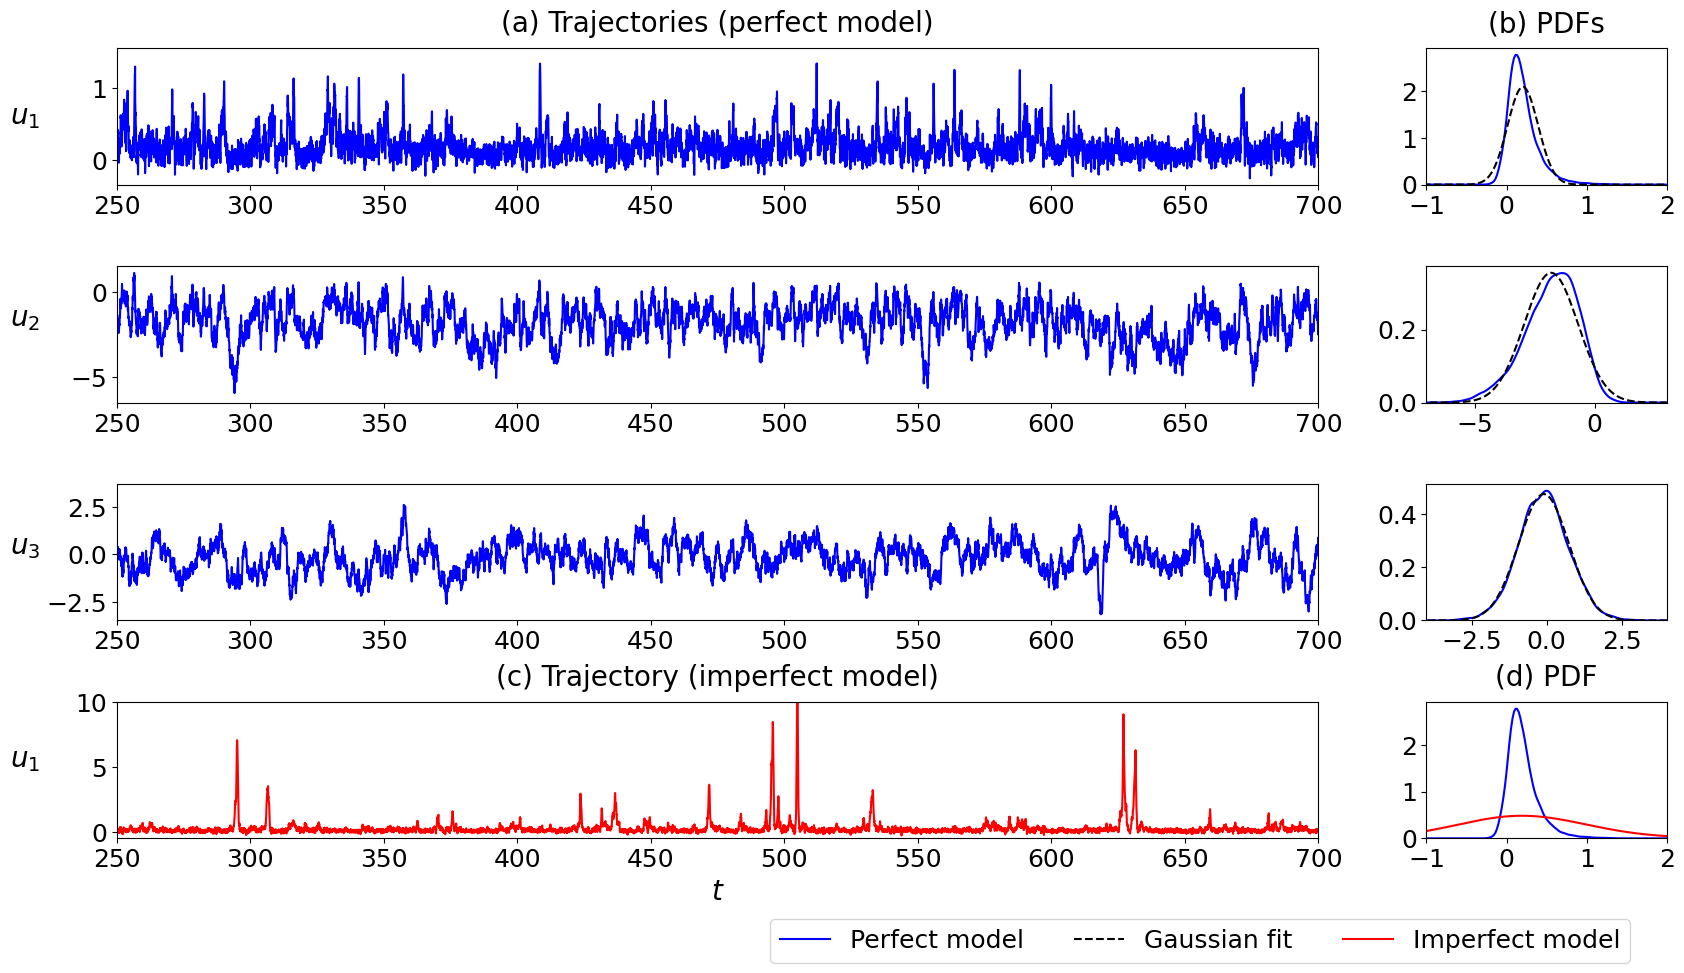

In [210]:
fontsize = 18
plt.rc("axes", titlepad=12)
plt.rc("axes", titlesize=fontsize + 2)
plt.rc("axes", labelsize=fontsize + 2)
plt.rc("xtick", labelsize=fontsize)
plt.rc("ytick", labelsize=fontsize)
plt.rc("legend", fontsize=fontsize)

fig, axs = plt.subplots(
    nrows=model_dim + 1,
    ncols=2,
    figsize=(20, 2.5 * (model_dim + 1)),
    gridspec_kw={"width_ratios": [5, 1]},
)

x_left = 250
x_right = 700

for i in range(model_dim):
    plt_dim = i
    axs[i, 0].plot(
        t_obs[obs_burnin:],
        true_state[obs_idx, plt_dim][obs_burnin:],
        "b",
    )
    axs[i, 0].set_xlim([x_left, x_right])
    u = true_state[obs_idx, plt_dim][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u, num=400, dist=3)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="b", label="Perfect model")

    u_mean, u_std = norm.fit(u)
    axs[i, 1].plot(
        u_axis,
        norm.pdf(u_axis, u_mean, u_std),
        "--",
        color="black",
        label="Gaussian fit",
    )
    axs[i, 0].set_xlim([x_left, x_right])
    axs[i, 1].set_ylim(bottom=0)
    axs[i, 0].locator_params(axis="y", nbins=3)
    axs[i, 1].locator_params(nbins=3)

for plt_dim in range(1):
    i = plt_dim + model_dim

    u = true_state[obs_idx, plt_dim][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u, num=400, dist=3)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="b")
    axs[i, 0].plot(
        t_obs[obs_burnin:],
        wrong_state[obs_idx, plt_dim][obs_burnin:],
        "r",
        label="Imperfect model",
    )
    axs[i, 0].set_xlim([x_left, x_right])
    u = np.sort(wrong_state[obs_idx, 0])[: 20000 - 70]
    kde_u, u_axis = compute_kde_axis(u, num=20000, dist=3)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="r")

    axs[i, 0].set_xlim([x_left, x_right])
    axs[i, 0].set_ylim([-0.5, 10])
    axs[i, 1].set_ylim(bottom=0)
    axs[i, 0].locator_params(axis="y", nbins=3)
    axs[i, 1].locator_params(nbins=3)

x_loc = x_left - 40
axs[0, 0].text(x_loc, 0.5, "$u_1$", fontsize=fontsize + 2)
axs[1, 0].text(x_loc, -2, "$u_2$", fontsize=fontsize + 2)
axs[2, 0].text(x_loc, 0, "$u_3$", fontsize=fontsize + 2)
axs[3, 0].text(x_loc, 5, "$u_1$", fontsize=fontsize + 2)
axs[0, 1].set_xlim([-1, 2])
axs[1, 1].set_xlim([-7, 3])
axs[2, 1].set_xlim([-4, 4])
axs[3, 1].set_xlim([-1, 2])

axs[0, 0].set_title("(a) Trajectories (perfect model)")
axs[0, 1].set_title("(b) PDFs")
axs[3, 0].set_title("(c) Trajectory (imperfect model)")
axs[3, 1].set_title("(d) PDF")
axs[-1, 0].set_xlabel("$t$")

handles1, labels1 = axs[0, 1].get_legend_handles_labels()
handles2, labels2 = axs[-1, 0].get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
axs[-1, 1].legend(
    handles, labels, ncol=3, loc="upper right", bbox_to_anchor=(0.9, -0.5)
)

plt.subplots_adjust(hspace=0.6, wspace=0.15, top=0.9)
savefig(
    fig, osp.join(output_path, model + "_trajectory_truth_vs_wrong" + ".pdf")
)

plt.rcdefaults()

In [84]:
acf_u_smooth = np.zeros((auto_obs_steps, model_dim))
acf_u_sampled = np.zeros((auto_obs_steps, model_dim))
for i in tqdm(range(model_dim)):
    acf_u_smooth[:, i] = estimated_autocorrelation(
        gamma_mean_smooth[:, i][obs_burnin:]
    )
    acf_u_sampled[:, i] = estimated_autocorrelation(
        gamma_ensembles[:, i, 0][obs_burnin:]
    )

100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


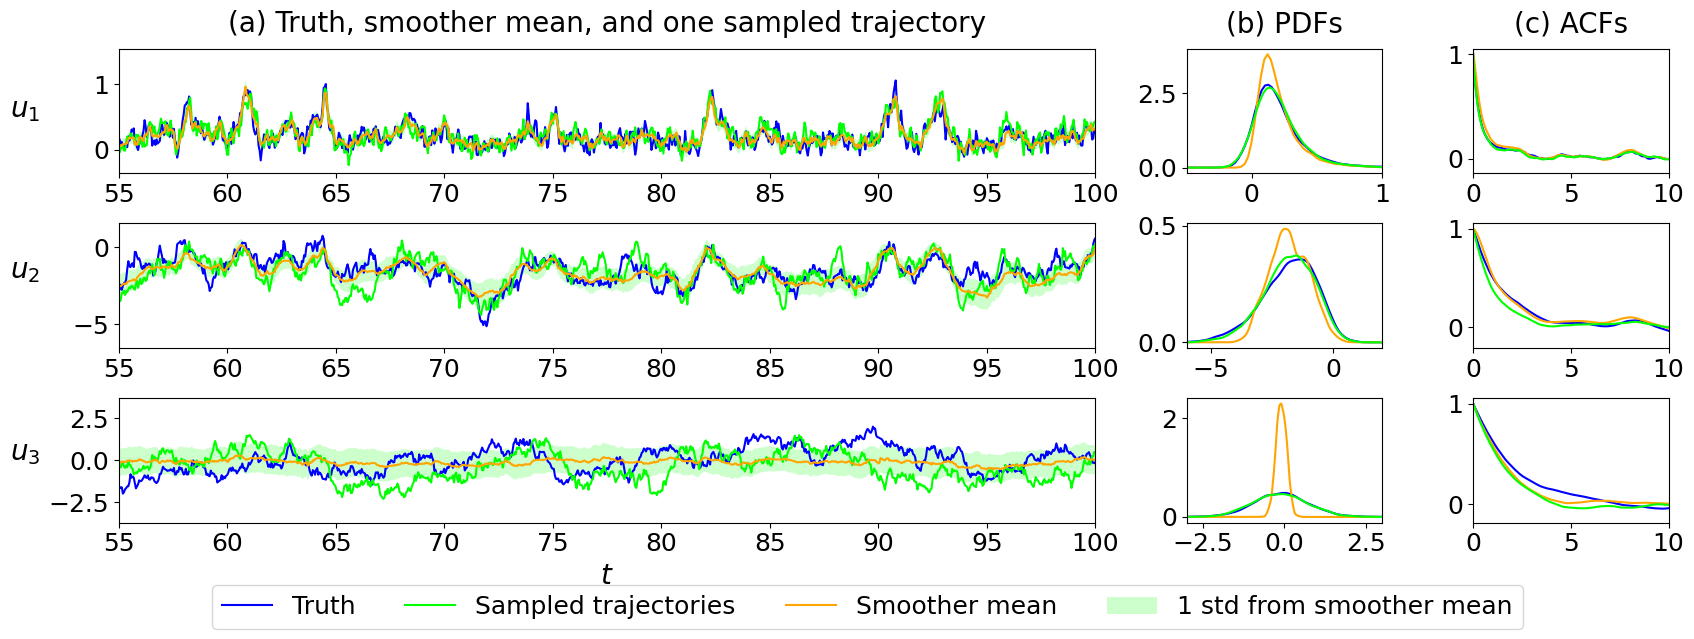

In [134]:
fontsize = 18
plt.rc("axes", titlesize=fontsize + 2)  # using a size in points
plt.rc("xtick", labelsize=fontsize)
plt.rc("ytick", labelsize=fontsize)
plt.rc("legend", fontsize=fontsize)

fig, axs = plt.subplots(
    nrows=model_dim,
    ncols=3,
    figsize=(20, 2 * (model_dim)),
    gridspec_kw={"width_ratios": [5, 1, 1]},
)

title = [
    "$u_1$",
    "$u_2$",
    "$u_3$",
]

x_left = 55
x_right = 100

for i in range(model_dim):
    axs[i, 0].plot(
        t_obs[obs_burnin:],
        np.real(true_state)[obs_idx, i][obs_burnin:],
        "b",
        label="Truth",
    )
    axs[i, 0].set_xlim([x_left, x_right])
    u = np.real(true_state[obs_idx, i])[obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u, num=300, dist=3)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="b")
    axs[i, 2].plot(t_auto, acf_u_truth[:, i], color="b")
    u = np.real(gamma_mean_smooth)[:, i][obs_burnin:]
    kde_u, u_axis = compute_kde_axis(u, num=300, dist=3)
    axs[i, 1].plot(u_axis, kde_u(u_axis), color="orange")
    axs[i, 2].plot(t_auto, acf_u_smooth[:, i], color="orange")
    for j in range(1):
        # j is number of the sampled trajectories
        u = np.real(gamma_ensembles)[:, i, j][obs_burnin:]
        kde_u, u_axis = compute_kde_axis(u, num=300, dist=3)
        axs[i, 1].plot(u_axis, kde_u(u_axis), color="lime")
        axs[i, 2].plot(t_auto, acf_u_sampled[:, i], color="lime")
        smoothing_upper_u = np.real(gamma_mean_smooth)[:, i][
            obs_burnin:
        ] + np.sqrt(np.real(gamma_cov_smooth)[:, i, i][obs_burnin:])
        smoothing_lower_u = np.real(gamma_mean_smooth)[:, i][
            obs_burnin:
        ] - np.sqrt(np.real(gamma_cov_smooth)[:, i, i][obs_burnin:])
        axs[i, 0].plot(
            t_obs[obs_burnin:],
            np.real(gamma_ensembles)[:, i, j][obs_burnin:],
            "lime",
            label="Sampled trajectories",
        )
        axs[i, 0].fill_between(
            t_obs[obs_burnin:],
            smoothing_upper_u,
            smoothing_lower_u,
            facecolor="lime",
            alpha=0.2,
            label="1 std from smoother mean",
        )

    axs[i, 0].plot(
        t_obs[obs_burnin:],
        np.real(gamma_mean_smooth)[:, i][obs_burnin:],
        "orange",
        label="Smoother mean",
    )

    axs[i, 2].set_xlim([0, 10])


x_loc = x_left - 5
axs[0, 0].text(x_loc, 0.5, "$u_1$", fontsize=fontsize + 2)
axs[1, 0].text(x_loc, -2, "$u_2$", fontsize=fontsize + 2)
axs[2, 0].text(x_loc, 0, "$u_3$", fontsize=fontsize + 2)
axs[0, 1].set_xlim([-0.5, 1])
axs[1, 1].set_xlim([-6, 2])
axs[2, 1].set_xlim([-3, 3])

axs[0, 0].set_title(
    "(a) Truth, smoother mean, and one sampled trajectory", pad=12
)
axs[0, 1].set_title("(b) PDFs", pad=12)
axs[0, 2].set_title("(c) ACFs", pad=12)
axs[-1, 0].set_xlabel("$t$")
plt.subplots_adjust(hspace=0.4, top=0.9)

handles, labels = axs[0, 0].get_legend_handles_labels()
axs[-1, 0].legend(
    handles, labels, ncol=4, loc="upper right", bbox_to_anchor=(1.45, -0.40)
)
savefig(
    fig,
    osp.join(output_path, model + "_PDFs_ACFs.pdf"),
)